In [76]:
#Importing the Libraries
import numpy as np
import pandas as pd
import plotly.graph_objs as go
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Data preparation

In [54]:
#Loading the dataset
data = pd.read_csv("../datasets/Customer/Customer.csv",encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [55]:
print('Dataframe dimensions:', data.shape)

Dataframe dimensions: (541909, 8)


In [56]:
#Information on features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


Given the number of null values in the dataframe, you found about 100000 of customer id are null. Given the data and subject matter, rows rhat do not have a customer_id are useless so i will delete them from the dataframe:

In [57]:
# Copy the 'data' DataFrame to 'clean_data'
clean_data = data.copy()
clean_data.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions after delete null Customers_ID:', clean_data.shape)

Dataframe dimensions after delete null Customers_ID: (406829, 8)


In [58]:
#check for duplicate entries and delete them
print('Duplicate Entries: {}'.format(clean_data.duplicated().sum()))
clean_data.drop_duplicates(inplace = True)

Duplicate Entries: 5225


## 2.EDA

### 2.1 Customers and products

In [59]:
pd.DataFrame([{'customers': len(clean_data['CustomerID'].value_counts()),    
               'products': len(clean_data['StockCode'].value_counts()),
               'transactions': len(clean_data['InvoiceNo'].value_counts()),  
              }], columns = ['customers', 'products', 'transactions'], index = ['Total'])

,customers,products,transactions
Total,4372,3684,22190


We found that 4,372 customers  purchased 3,684 different products. They made approximately 22,000 purchases in total.

In [60]:
#calculate how many products were bought in each individual purchase.
products_per_basket=clean_data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count().rename(columns = {'InvoiceDate':'Number of products'})

In [61]:
products_per_basket.sort_values('Number of products')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
12809,15615,C554874,1
12808,15615,C550454,1
12799,15615,562919,1
12791,15615,550450,1
...,...,...,...
6808,14096,573576,435
6811,14096,578270,442
6813,14096,580727,529
6812,14096,579196,533


In [75]:
#determine the number of products purchased in every transaction
temp = clean_data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12347,537626,31
2,12347,542237,29
3,12347,549222,24
4,12347,556201,18
5,12347,562032,22
6,12347,573511,47
7,12347,581180,11
8,12348,539318,17
9,12348,541998,6


The beginning of this data reveals several interesting points:
    -Some InvoiceNo entries start with "C". This signifies cancelled transactions.
    -There are users who made only one purchase of a single product (for example, user #12346).
    -There are also frequent users who buy many items in each order.

let's find  the number of transactions corresponding to canceled orders:

In [62]:
products_per_basket['order_canceled'] = products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(products_per_basket[:10])

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0
5,12347,556201,18,0
6,12347,562032,22,0
7,12347,573511,47,0
8,12347,581180,11,0
9,12348,539318,17,0


In [63]:
No_c = products_per_basket['order_canceled'].sum()
No_p = products_per_basket.shape[0]
print('Number of orders canceled and the percentage: {}/{} ({:.2f}%) '.format(No_c, No_p, No_c/No_p*100))

Number of orders canceled and the percentage: 3654/22190 (16.47%) 


In [64]:
data.sort_values('Quantity')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,12/9/2011 9:27,2.08,16446,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/2011 10:17,1.04,12346,United Kingdom
225529,556690,23005,printing smudges/thrown away,-9600,6/14/2011 10:37,0.00,NaN,United Kingdom
225530,556691,23005,printing smudges/thrown away,-9600,6/14/2011 10:37,0.00,NaN,United Kingdom
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,12/2/2010 14:23,0.03,15838,United Kingdom
...,...,...,...,...,...,...,...,...
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,10/27/2011 12:26,0.21,12901,United Kingdom
74614,542504,37413,NaN,5568,1/28/2011 12:03,0.00,NaN,United Kingdom
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,11/25/2011 15:57,0.00,13256,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346,United Kingdom


In [65]:
# Delete rows where 'Quantity' is less than or equal to 0
clean_data = clean_data[clean_data['Quantity'] > 0]

# Display the cleaned DataFrame
clean_data.shape

(392732, 8)

let's work on StockCode

In [66]:
clean_data[clean_data['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()

array(['POST', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'], dtype=object)

C:\Users\hp\AppData\Local\Temp\ipykernel_19680\436577444.py:9: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




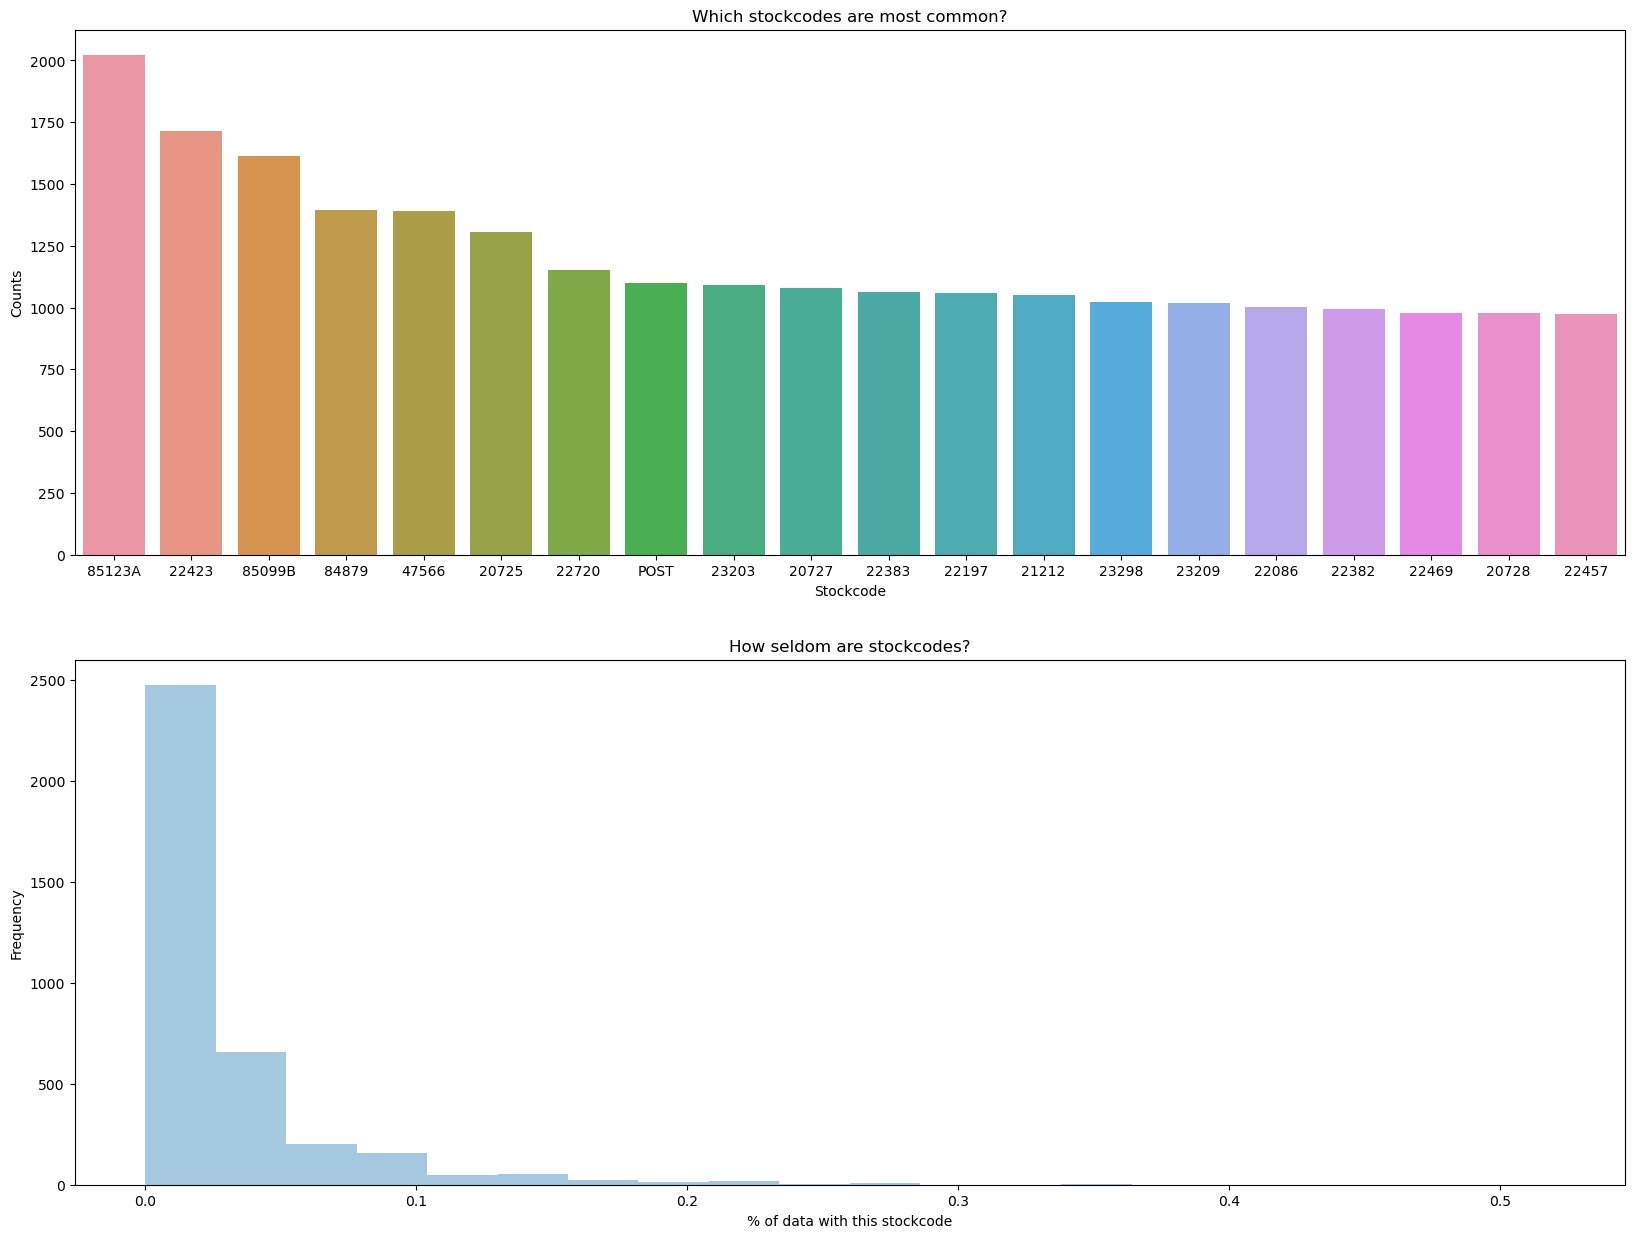

In [86]:
stockcode_counts = clean_data['StockCode'].value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(2,1,figsize=(20,15))
sns.barplot(x=stockcode_counts.iloc[0:20].index,
            y=stockcode_counts.iloc[0:20].values,
            ax = ax[0])
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Stockcode")
ax[0].set_title("Which stockcodes are most common?");
sns.distplot(np.round(stockcode_counts/clean_data.shape[0]*100,2),
             kde=False,
             bins=20,
             ax=ax[1])
ax[1].set_title("How seldom are stockcodes?")
ax[1].set_xlabel("% of data with this stockcode")
ax[1].set_ylabel("Frequency");

create a new Freature *TotalPrice* that equal total price of every purchase:

In [67]:
clean_data['TotalPrice'] = clean_data['UnitPrice'] * clean_data['Quantity'] 
clean_data.sort_values('TotalPrice')[:10]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
298054,562973,23157,SET OF 6 NATIVITY MAGNETS,240,8/11/2011 11:42,0.0,14911,EIRE,0.0
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,1/13/2011 15:10,0.0,15107,United Kingdom,0.0
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,11/25/2011 15:57,0.0,13256,United Kingdom,0.0
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,4/4/2011 14:42,0.0,14410,United Kingdom,0.0
436597,574175,22065,CHRISTMAS PUDDING TRINKET POT,12,11/3/2011 11:47,0.0,14110,United Kingdom,0.0
395529,571035,M,Manual,1,10/13/2011 12:50,0.0,12446,RSA,0.0
285657,561916,M,Manual,1,8/1/2011 11:44,0.0,15581,United Kingdom,0.0
439361,574469,22385,JUMBO BAG SPACEBOY DESIGN,12,11/4/2011 11:55,0.0,12431,Australia,0.0
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,3/23/2011 10:25,0.0,13239,United Kingdom,0.0
314747,564651,22955,36 FOIL STAR CAKE CASES,144,8/26/2011 14:19,0.0,14646,Netherlands,0.0


In [68]:
clean_data[clean_data['UnitPrice'] <= 0].shape[0]

40

as we see above there are *40* rows with zero *TotalPrice* bz its *UnitPrice* is zero

In [69]:
# Delete rows where 'UnitPrice' is  equal to 0
clean_data = clean_data[clean_data['UnitPrice'] > 0]

# Display the cleaned DataFrame
clean_data.shape

(392692, 9)

### 2.2 Countries
let's look at the countries

In [71]:
countries=clean_data['Country'].value_counts()

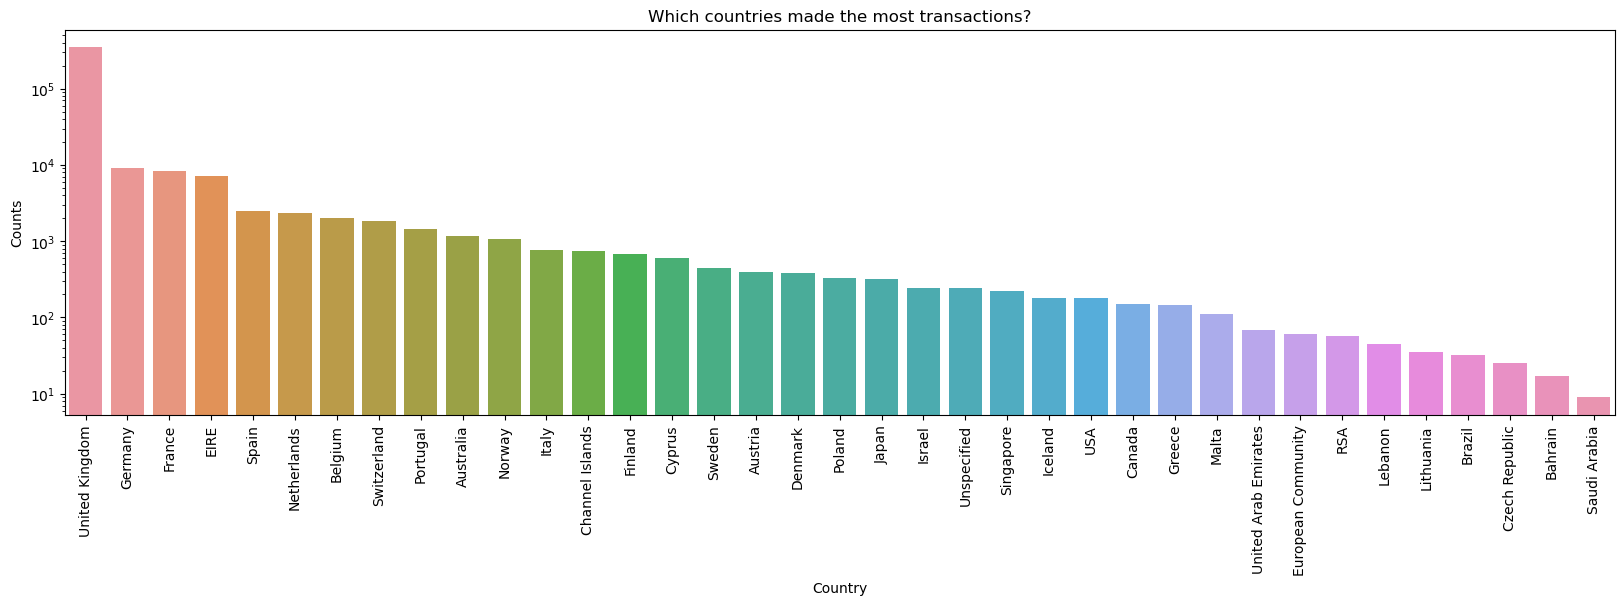

In [87]:

plt.figure(figsize=(20,5))
sns.barplot(x=countries.index, y=countries.values)
plt.ylabel("Counts")
plt.title("Which countries made the most transactions?");
plt.xticks(rotation=90);
plt.yscale("log")

In [74]:

data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

## 3. Create clusters